# **Simulador IRB 140 Sin Ruido**

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from IPython.display import HTML
from scipy.integrate import solve_ivp

# la funcionalidad específica de robótica está en el toolbox
import roboticstoolbox as rtb
# spatialmath tiene define los grupos de transformaciones especiales: rotación SO3 y eculideo SE3
import spatialmath as sm
from spatialmath import SE3
import os
import time
from datetime import datetime
fecha_actual = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')

In [17]:
# Extiendo la clase DHRobot para que incluya el generador de trayectorias joint y cartesiano
from roboticstoolbox import DHRobot, RevoluteDH

class DHRobotGT(DHRobot):
  def __init__(self, *args, tacc=0.1, Ts=1E-3,vmax=np.array([2*np.pi,2*np.pi]), **kwargs):
    super().__init__(*args, **kwargs)
    self.tacc = tacc #Tiempo de aceleracion
    self.Ts = Ts #Intervalo de muestreo
    self.vmax = vmax #Velocidad maxima de las aceleraciones

  def interpoladorTrapezoidal(self,A,B,C,Tj):
    #Lo necesito para los movimientos en espacio de joints, para evitar que las aceleraciones sean deltas (limitacion en torques aplicados x dinamica inversa)
    """
    Interpolador trapezoidal en zona 1 y 2

    Args:
      A: punto en el que estoy
      B: punto al que estaba yendo en el segmento anterior
      C: punto al que voy
      Tj: tiempo en que se realiza el movimiento

    Returns:
      q_aux: vector interpolado de posiciones
      qd_aux: vector interpolado de velocidades
      qdd_aux: vector interpolado de aceleraciones
    """
    DA = A-B
    DC = C-B

    # Zona 1
    # Generar el vector tseg para Zona 1 -> Zona de aceleracion
    tseg = np.arange(-self.tacc + self.Ts, self.tacc + self.Ts, self.Ts) #

    # Calculo las referencias para zona 1
    qdd_aux = np.outer((DC/Tj+DA/self.tacc)/(2*self.tacc),np.ones(len(tseg)))
    qd_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc) / (2 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc) / (2 * self.tacc)
    q_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc)**2 / (4 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc)**2 / (4 * self.tacc) + np.outer(B,np.ones(len(tseg)))

    # Zona 2
    # Generar el vector tseg para Zona 2
    tseg = np.arange(self.tacc + self.Ts, Tj - self.tacc + 0.5* self.Ts , self.Ts)

    # Inicializar las matrices theta2p, thetap y theta
    qdd_aux = np.hstack([qdd_aux,np.zeros((len(B), len(tseg)))])   # Suponiendo que B es un vector
    qd_aux = np.hstack([qd_aux,np.outer(DC / Tj, np.ones(len(tseg)))])
    q_aux = np.hstack([q_aux,np.outer(DC / Tj, tseg) +  np.outer(B,np.ones(len(tseg)))])
    return q_aux,qd_aux,qdd_aux

  def genTrJoint(self, q_dest,Td):
    """
    Genera la trayectoria joint para un conjunto de puntos de paso

    Args:
      q_dest: Matriz con los puntos de paso. Cada fila corresponde a un punto
      Td: tiempos deseados de cada movimiento

    Returns:
      t: Vector de tiempo de referencia
      q: Vector de posiciones articulares de referencia
      qd: Vector de velocidades articulares de referencia
      qdd: Vector de aceleraciones articulares de referencia
      POSES: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    """
    q = np.empty((self.nlinks,0)); qd = np.empty((self.nlinks,0)); qdd = np.empty((self.nlinks,0))
    A = q_dest[0,:];
    for i in range(len(q_dest)):
      B = q_dest[i,:]
      if i<len(q_dest)-1:
        C = q_dest[i+1,:]
      else:
        C = B
        Td[i] = 0
      Tj = np.max((np.max(np.abs(C-B)/self.vmax),Td[i],2*self.tacc))
      q_aux,qd_aux,qdd_aux = self.interpoladorTrapezoidal(A,B,C,Tj)
      q = np.hstack([q,q_aux]); qd = np.hstack([qd,qd_aux]); qdd = np.hstack([qdd,qdd_aux]);
      A = q[:,-1]
    t = np.linspace(0, q.shape[1],num=q.shape[1])*self.Ts

    # Calculo la trayectoria cartesiana deseada
    POSES = self.fkine(q.transpose()) # .extend([self.fkine(q[:,i]) for i in range(q.shape[1])])
    return t,q.transpose(),qd.transpose(),qdd.transpose(),POSES

  def genTrCart_2(self,POSE_dest,Td):
    """
    Genera la trayectoria cartesiana para un conjunto de puntos de paso

    Args:
      POSE_dest: Lista con las POSES de paso
      Td: tiempos deseados de cada movimiento

    Returns:
      t: Vector de tiempo de referencia
      q: Vector de posiciones articulares de referencia
      qd: Vector de velocidades articulares de referencia
      qdd: Vector de aceleraciones articulares de referencia
      POSES: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    """

    POSEA = POSE_dest[0]
    POSES = []
    for i in range(len(POSE_dest)):
      POSEB = POSE_dest[i]
      if i<len(POSE_dest)-1:
        POSEC = POSE_dest[i+1]
      else:
        C = B
        Td[i] = 0
      A = np.concatenate((POSEA.t,POSEA.eulervec()))
      B = np.concatenate((POSEB.t,POSEB.eulervec()))
      C = np.concatenate((POSEC.t,POSEC.eulervec()))
      Tj = np.max([Td[i],2*self.tacc])

      pos,_,_ = self.interpoladorTrapezoidal(A,B,C,Tj)
      POSES.extend([sm.SE3(pos[0:3,j])*sm.SE3.EulerVec(pos[3:,i]) for j in range(pos.shape[1])])

      POSEA = POSES[-1]

    q = np.zeros((len(POSES),self.nlinks))
    for i in range(len(POSES)):
      q[i,:],_ = self.ikine_a(POSES[i])


    # Obtengo la velocidad articular derivando numéricamente
    qd = np.diff(q, axis=0) / self.Ts
    # Ajustar la longitud de qd para que coincida con q
    qd = np.vstack([qd, np.zeros(self.nlinks,)])

    # Obtengo la aceleración articular derivando numéricamente
    qdd = np.diff(qd, axis=0) / self.Ts
    # Ajustar la longitud de qdd para que coincida con qd
    qdd = np.vstack([qdd, np.zeros(self.nlinks,)])

    t = np.linspace(0, len(q),num=len(q))*self.Ts
    return t,q,qd,qdd,POSES



  def genTrCart(self, POSE_dest, Td):
    POSEA = POSE_dest[0]
    POSES = []
    for i in range(len(POSE_dest)):
        POSEB = POSE_dest[i]
        if i < len(POSE_dest) - 1:
            POSEC = POSE_dest[i + 1]
        else:
            C = B
            #POSEC = POSEB  # Asegúrate de que POSEC no sea reutilizado incorrectamente
            Td[i] = 0

        A = np.concatenate((POSEA.t, POSEA.eulervec()))
        B = np.concatenate((POSEB.t, POSEB.eulervec()))
        C = np.concatenate((POSEC.t, POSEC.eulervec()))
        Tj = np.max([Td[i], 2 * self.tacc])

        # Realizar interpolación trapezoidal
        pos, _, _ = self.interpoladorTrapezoidal(A, B, C, Tj)
        POSES.extend([sm.SE3(pos[0:3,j])*sm.SE3.EulerVec(pos[3:,i]) for j in range(pos.shape[1])])


        # Asegurar interpolación correcta de las rotaciones
        #for j in range(pos.shape[1]):
        #    transl = pos[0:3, j]
        #    rot = sm.SE3.EulerVec(pos[3:, j])
        #    pose = sm.SE3(transl) * rot
        #    POSES.append(pose)

        POSEA = POSES[-1]

    # Resolver la cinemática inversa para todas las poses
    q = np.zeros((len(POSES), self.nlinks))
    for i in range(len(POSES)):
        q[i, :], _ = self.ikine_a(POSES[i])

    # Derivar numéricamente para obtener qd y qdd
    qd = np.diff(q, axis=0) / self.Ts
    qd = np.vstack([qd, np.zeros(self.nlinks,)])

    qdd = np.diff(qd, axis=0) / self.Ts
    qdd = np.vstack([qdd, np.zeros(self.nlinks,)])

    t = np.linspace(0, len(q), num=len(q)) * self.Ts
    return t, q, qd, qdd, POSES


In [18]:
class IRB140(DHRobotGT):
    def __init__(self, *args, **kwargs):
        # Defining the links with DH parameters
        # These parameters (a, alpha, d, offset) are placeholders and should be replaced with the real IRB 140 parameters
        links = [
            rtb.RevoluteDH(a=0, alpha=np.pi/2, d=0.352, offset=0, m=10, r=[0, 0, 0.1], I=np.eye(3)),
            rtb.RevoluteDH(a=0.7, alpha=0, d=0, offset=0, m=7.5, r=[0.35, 0, 0], I=np.eye(3)),
            rtb.RevoluteDH(a=0, alpha=np.pi/2, d=0, offset=0, m=5, r=[0, 0, 0.1], I=np.eye(3)),
            rtb.RevoluteDH(a=0, alpha=-np.pi/2, d=0.7, offset=0, m=2.5, r=[0, 0, 0.05], I=np.eye(3)),
            rtb.RevoluteDH(a=0, alpha=np.pi/2, d=0, offset=0, m=1.5, r=[0, 0, 0.03], I=np.eye(3)),
            rtb.RevoluteDH(a=0, alpha=0, d=0.1, offset=0, m=0.8, r=[0, 0, 0.02], I=np.eye(3)),
        ]

        self.num_links = 6

        # Adding frictionless property to links
        #links = [link.nofriction() for link in [link1, link2, link3, link4, link5, link6]]

        # Creating the robot structure
        super().__init__(*args, links, name='IRB140', gravity=np.array([0, 0, -9.81]), **kwargs)

    #def ikine_a(self, POSE, conf=1):
    def ikine_a(self, POSE, conf=(1, 1, 1)):
        """
        Cinemática inversa analítica para el robot ABB IRB 140

        Args:
        POSE: Posición y orientación deseada en el espacio (4x4 SE3 matriz o numpy.ndarray)
        conf: Configuración del robot (hombro, codo, muñeca):
                - Hombro: 1 (izquierda) o -1 (derecha)
                - Codo: 1 (arriba) o -1 (abajo)
                - Muñeca: 1 (no-flip) o -1 (flip)

        Returns:
        q: Lista con las posiciones articulares [q1, q2, q3, q4, q5, q6] en radianes
        status: Estado del algoritmo (<0 si hay error, 0 si tiene éxito)
        """
        shoulder, elbow, wrist = conf

        # Definición de parámetros DH del IRB 140 (en metros)
        a1 = self.links[0].a
        a2 = self.links[1].a
        a3 = self.links[2].a
        d1 = self.links[0].d
        d4 = self.links[3].d
        d6 = self.links[5].d

        # Extraer rotación y posición de la matriz de transformación
        if isinstance(POSE, SE3):
            POSE = POSE.A
        R_des = POSE[:3, :3]
        p_des = POSE[:3, 3]

        x, y, z = p_des

        # Cálculo de q1 (hombro)
        r1 = math.sqrt(x**2 + y**2 - a1**2)
        if r1 < 0:
            print("El punto no es alcanzable por el robot.")
            return None, -1
        
        q1 = math.atan2(y, x) - shoulder * math.acos(a1 / math.sqrt(x**2 + y**2))

        # Centro de la muñeca (WC)
        wx = x - d6 * R_des[0, 2]
        wy = y - d6 * R_des[1, 2]
        wz = z - d6 * R_des[2, 2]

        # Cálculo de q3 (codo)
        r2 = math.sqrt((wx - a1 * math.cos(q1))**2 + (wy - a1 * math.sin(q1))**2)
        s = wz - d1
        D = (r2**2 + s**2 - a2**2 - d4**2) / (2 * a2 * d4)

        if abs(D) > 1:
            print("El punto no es alcanzable por el codo.")
            return None, -1

        q3 = math.atan2(elbow * math.sqrt(1 - D**2), D)

        # Cálculo de q2 (articulación 2)
        k1 = a2 + d4 * math.cos(q3)
        k2 = d4 * math.sin(q3)
        q2 = math.atan2(s, r2) - math.atan2(k2, k1)

        # Matriz de rotación para la muñeca
        R0_3 = np.array([
            [math.cos(q1) * math.cos(q2 + q3), -math.cos(q1) * math.sin(q2 + q3), math.sin(q1)],
            [math.sin(q1) * math.cos(q2 + q3), -math.sin(q1) * math.sin(q2 + q3), -math.cos(q1)],
            [math.sin(q2 + q3), math.cos(q2 + q3), 0]
        ])

        R3_6 = R0_3.T @ R_des

        # Cálculo de q4, q5, q6 (muñeca)
        q5 = math.atan2(wrist * math.sqrt(R3_6[2, 0]**2 + R3_6[2, 1]**2), R3_6[2, 2])
        if abs(math.sin(q5)) > 1e-6:
            q4 = math.atan2(R3_6[1, 2], R3_6[0, 2])
            q6 = math.atan2(R3_6[2, 1], -R3_6[2, 0])
        else:
            q4 = 0
            q6 = math.atan2(-R3_6[0, 1], R3_6[0, 0])

        q = [q1, q2, q3, q4, q5, q6]
        status = 0
        return q, status


# Crear una instancia del IRB 140
irb140 = IRB140(
    Ts=1E-3,                 # Tiempo de muestreo
    tacc=0.2,                # Tiempo de aceleración
    vmax=np.array([2, 2, 2, 2, 2, 2])  # Velocidades máximas por articulación (ejemplo)
)

# Puntos iniciales y finales de configuración
qr = np.array([-np.pi/2, 0, 0, 0, 0, 0])  # Configuración inicial
qz = np.zeros((6,))                       # Configuración cero

# Imprimir la instancia y sus características dinámicas
print(irb140)
print(irb140.dynamics())  # Muestra las características dinámicas (si están definidas)


DHRobot: IRB140, 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬───────┬─────┬────────┐
│ θⱼ  │  dⱼ   │ aⱼ  │   ⍺ⱼ   │
├─────┼───────┼─────┼────────┤
│  q1 │ 0.352 │   0 │  90.0° │
│  q2 │     0 │ 0.7 │   0.0° │
│  q3 │     0 │   0 │  90.0° │
│  q4 │   0.7 │   0 │ -90.0° │
│  q5 │     0 │   0 │  90.0° │
│  q6 │   0.1 │   0 │   0.0° │
└─────┴───────┴─────┴────────┘

┌──┬──┐
└──┴──┘

┌───────┬──────┬───────────────┬────────────────────────┬────┬────┬────────┬────┐
│   j   │  m   │       r       │           I            │ Jm │ B  │   Tc   │ G  │
├───────┼──────┼───────────────┼────────────────────────┼────┼────┼────────┼────┤
│ link1 │  10  │  0,  0,  0.1  │  1,  1,  1,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
│ link2 │  7.5 │  0.35,  0,  0 │  1,  1,  1,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
│ link3 │  5   │  0,  0,  0.1  │  1,  1,  1,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
│ link4 │  2.5 │  0,  0,  0.05 │  1,  1,  1,  0,  0,  0 │  0 │  0 │  0,  0 │  0 │
│ link5 │  1.5 │  0,  0,  0.0

In [19]:
# Define joint positions, velocities, and accelerations
q = np.deg2rad([0, 45, 90, 0, 45, 0])  # Joint angles in radians
qd = np.zeros(6)  # Joint velocities
qdd = np.zeros(6)  # Joint accelerations

# Compute torques using rne
tau = irb140.rne(q, qd, qdd)

# Print the resulting torques
print("Joint torques:", tau)

Joint torques: [-9.53526467e-17  1.28988262e+02  2.67757296e+01 -8.67089690e-01
  2.50466314e-16  0.00000000e+00]


In [20]:
def generarRandomSamples(robot,N_samples=50000,show_histo=False):
  np.random.seed(42)            # Para reproducibilidad

  # Genero valores aleatorios para posición de los ejes y sus derivadas
  # 2 7 35
  q = np.array([3.49, 3.49, 4.54, , 0.5, 0.2])*np.random.randn(N_samples, robot.nlinks)
  qd = np.array([3.49, 3.49, 4.54, , 0.5, 0.2])*np.random.randn(N_samples, robot.nlinks)
  qdd = np.array([3.49, 3.49, 4.54, , 0.5, 0.2])*np.random.randn(N_samples, robot.nlinks)

  tau = robot.rne(q,qd,qdd)

  if show_histo:
    num_features_X = 6
    for i in range(num_features_X):
        plt.subplot(3, 2, i + 1)
        plt.hist(X_back[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
        #plt.title(f'Histograma de X{i+1}')
        #plt.xlabel('Valor')
        #plt.ylabel('Frecuencia')
    plt.show()

    num_features_Y = 2
    for i in range(num_features_Y):
        plt.subplot(1, num_features_Y, i + 1)
        plt.hist(Y_back[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
        plt.title(f'Histograma de torques{i+1}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
    plt.show()
  return q,qd,qdd,tau


In [21]:
def generateRandomDataSet(robot,N_segments,flag_joint_move = False,flag_plot=False):
  """
  Genera un dataset para entrenamiento y pruebas

  Args:
    robot: Instancia del robot
    N_segments: Cantidad de puntos a visitar (fly by point). El movimiento empieza y termina con velocidad 0
    flag_joint_move: Indica si la secuencia de movimientos es joint o cartesiana
    flag_plot: Indica si se grafica la trayectoria deseada

  Returns:
    t_ref: Vector de tiempo de referencia
    q_ref: Vector de posiciones articulares de referencia
    qd_ref: Vector de velocidades articulares de referencia
    qdd_ref: Vector de aceleraciones articulares de referencia
    POSES_ref: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    tau_ref: Vector de torques de referencia calculado con la dinámica directa para realizar la trayectoria de referencia

  """
  alcanceXY = robot.a[0]+robot.a[1]
  Tj = np.random.rand(N_segments, )+0.5
  if flag_joint_move:
    q_dest = (np.random.rand(N_segments, robot.num_links)-0.5)*2*np.pi
    t_ref,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrJoint(q_dest,Tj)
  else:
    # Limito las poses destino para trabajar en 2 cuadrantes y evitar pasar por singularidades
    POSE_dest = []
    while len(POSE_dest) < N_segments:
      x_dest = np.random.uniform(0, alcanceXY)
      y_dest = np.random.uniform(-alcanceXY, alcanceXY)
      if x_dest**2 + y_dest**2 < alcanceXY**2:
        POSE_dest.append(sm.SE3(x_dest, y_dest, 0))
    t_ref,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrCart(POSE_dest,Tj)

  # Extraigo la posición del TCP para graficar
  pos_ref = np.vstack(([pose.t[0] for pose in POSES_ref], [pose.t[1] for pose in POSES_ref])).T

  # Obtengo la velocidad cartesiana derivando numéricamente
  posd_ref = np.diff(pos_ref, axis=0) / robot.Ts
  # Ajustar la longitud de qdd para que coincida con qd
  posd_ref = np.vstack([posd_ref, np.zeros(2,)])

  # Obtengo la aceleración cartesiana derivando numéricamente
  posdd_ref = np.diff(posd_ref, axis=0) / robot.Ts
  # Ajustar la longitud de qdd para que coincida con qd
  posdd_ref = np.vstack([posdd_ref, np.zeros(2,)])

  # Calculo con el PDI el torque para hacer esa trayectoria
  tau_ref = robot.rne(q_ref,qd_ref,qdd_ref)
  
  if flag_plot:
    # Muestro las variables joint deseadas
    plt.figure(figsize=(12, 8))
    plt.subplot(3,1,1)
    for i in range(robot.num_links):  # Iterar sobre el número de articulaciones
        plt.plot(t_ref, q_ref[:, i], label=f'q{i+1}')
    plt.legend(loc='upper right')
    #plt.plot(t_ref,q_ref)
    #plt.legend(['q1', 'q2']);  plt.ylabel('q')
    plt.title('Variables articulares de referencia')
    plt.subplot(3,1,2)
    for i in range(robot.num_links):  # Iterar sobre el número de articulaciones
        plt.plot(t_ref, qd_ref[:, i], label=f'qd{i+1}')
    plt.legend(loc='upper right')
    #plt.plot(t_ref,qd_ref)
    #plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
    plt.subplot(3,1,3)
    for i in range(robot.num_links):  # Iterar sobre el número de articulaciones
        plt.plot(t_ref, qdd_ref[:, i], label=f'qdd{i+1}')
    plt.legend(loc='upper right')
    #plt.plot(t_ref,qdd_ref)
    #plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
    plt.show()

    # Muestro las variables cartesianas deseadas
    plt.figure(figsize=(12, 8))
    plt.subplot(3,1,1)
    plt.plot(t_ref,pos_ref)
    plt.legend(['x', 'y']);  plt.ylabel('Posición')
    plt.title('Variables cartesianas de referencia')
    plt.subplot(3,1,2)
    plt.plot(t_ref,posd_ref)
    plt.legend(['vx', 'vy']);  plt.ylabel('Velocidad')
    plt.subplot(3,1,3)
    plt.plot(t_ref,posdd_ref)
    plt.legend(['a1', 'a2']); plt.xlabel('Tiempo'); plt.ylabel('Aceleración')
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(t_ref,tau_ref)
    plt.legend(['tau1', 'tau2']); plt.xlabel('Tiempo'); plt.ylabel('Torque')
    plt.title('Torque calculado para realizar trayectoria')
    plt.show()

  return t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref

# Generación de Datos Randomizados #

Estos datos no están correlacionados, no responden a ninguna trayectoria determinada (estilo ruido blanco), se utilizarán para el entrenamiento de las redes FF.

In [22]:
n_samp_val = 100000
# Genero los datos
q_ref,qd_ref,qdd_ref,tau_ref = generarRandomSamples(irb140,N_samples=n_samp_val,show_histo=False)

In [23]:
nombre_archivo = f'./irb140_randomsamples_{fecha_actual}.csv'

cantidad = n_samp_val

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        #archivo.write('ID, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2\n')
        archivo.write('ID, Theta_1, Theta_2, Theta_3, Theta_4, Theta_5, Theta_6, D_Theta_1, D_Theta_2, D_Theta_3, D_Theta_4, D_Theta_5, D_Theta_6, DD_Theta_1, DD_Theta_2, DD_Theta_3, DD_Theta_4, DD_Theta_5, DD_Theta_6, Torque_1, Torque_2, Torque_3, Torque_4, Torque_5, Torque_6\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        #time = t_ref[_]
        j_1 = q_ref[_][0]
        j_2 = q_ref[_][1]
        j_3 = q_ref[_][2]
        j_4 = q_ref[_][3]
        j_5 = q_ref[_][4]
        j_6 = q_ref[_][5]                
        d_j_1 = qd_ref[_][0]
        d_j_2 = qd_ref[_][1]
        d_j_3 = qd_ref[_][2]
        d_j_4 = qd_ref[_][3]
        d_j_5 = qd_ref[_][4]
        d_j_6 = qd_ref[_][5]
        dd_j_1 = qdd_ref[_][0]
        dd_j_2 = qdd_ref[_][1]
        dd_j_3 = qdd_ref[_][2]
        dd_j_4 = qdd_ref[_][3]
        dd_j_5 = qdd_ref[_][4]
        dd_j_6 = qdd_ref[_][5]
        tau_1 = tau_ref[_][0]
        tau_2 = tau_ref[_][1]
        tau_3 = tau_ref[_][2]
        tau_4 = tau_ref[_][3]
        tau_5 = tau_ref[_][4]
        tau_6 = tau_ref[_][5]

        archivo.write((
            f'{id}, {j_1}, {j_2}, {j_3}, {j_4}, {j_5}, {j_6}, '
            f'{d_j_1}, {d_j_2}, {d_j_3}, {d_j_4}, {d_j_5}, {d_j_6}, '
            f'{dd_j_1}, {dd_j_2}, {dd_j_3}, {dd_j_4}, {dd_j_5}, {dd_j_6}, '
            f'{tau_1}, {tau_2}, {tau_3}, {tau_4}, {tau_5}, {tau_6}\n'))


# Generación de Trayectorias Joint #

Estos valores representan una trayectoria en el espacio de Joints, por lo que la secuencia implica una correlación entre las muestras. Utilizadas para el entrenamiento de redes LSTM. ¿Qué pasa con el One-Step Ahead approach?

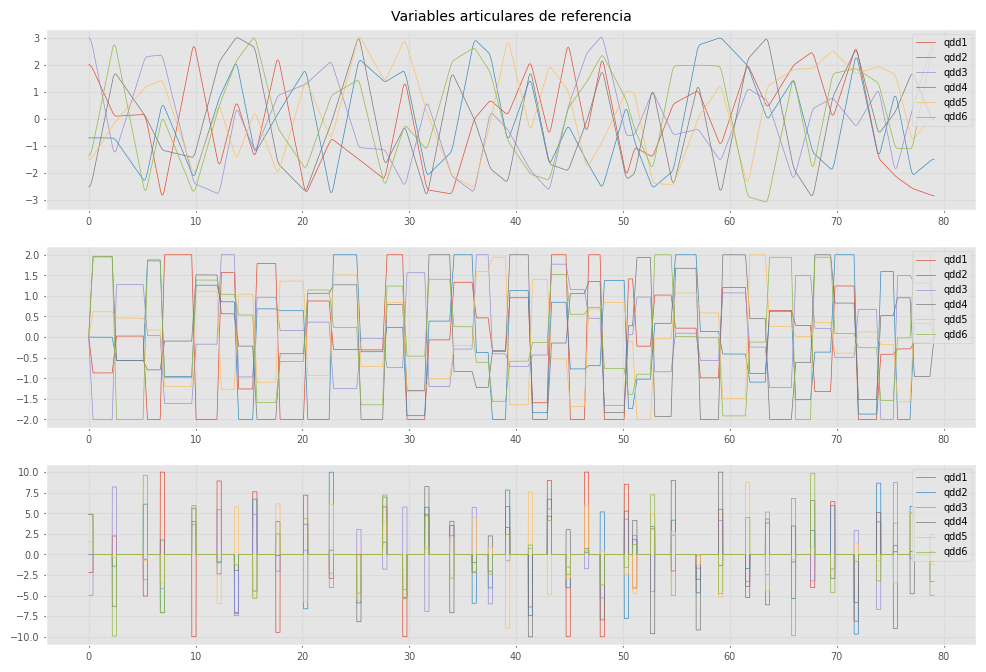

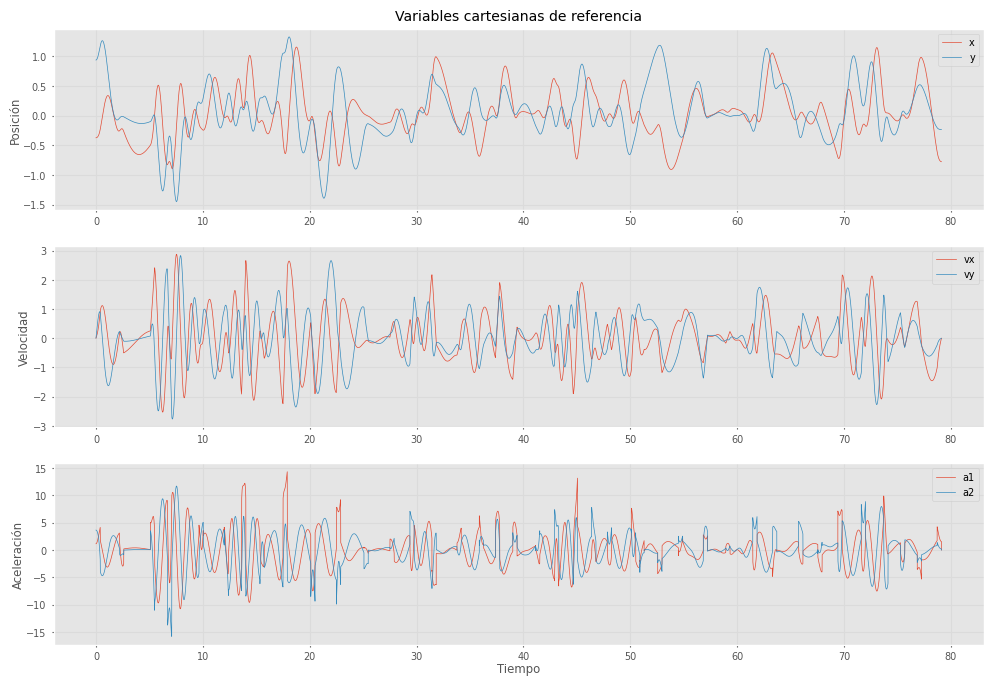

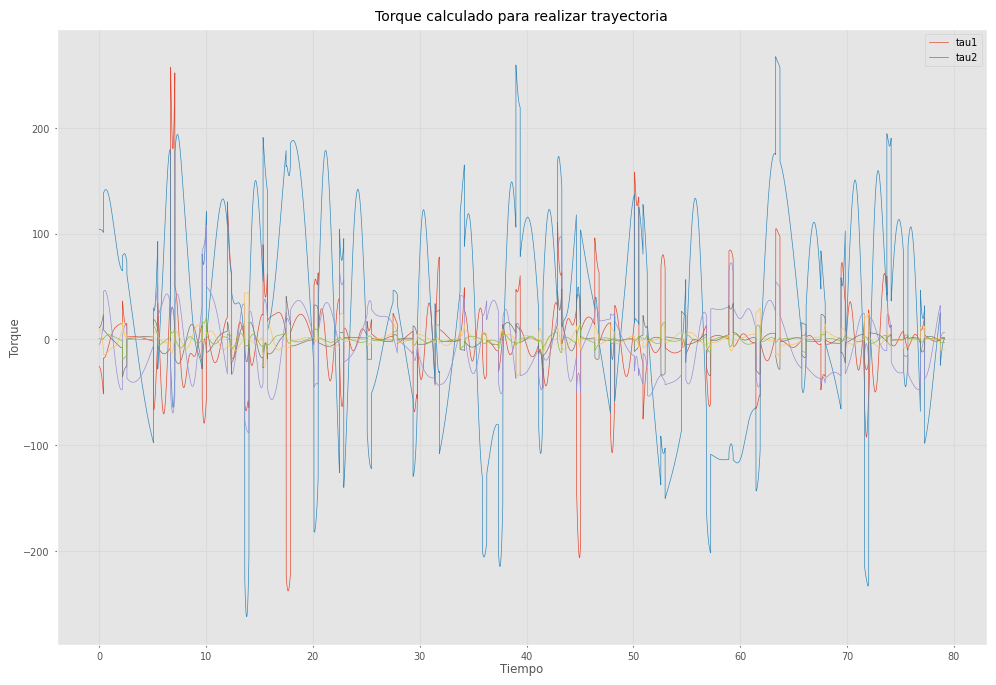

In [24]:
t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref = generateRandomDataSet(irb140,40,flag_joint_move = True,flag_plot=True)

In [25]:
nombre_archivo = f'./irb140_jointmovement_{fecha_actual}.csv'

cantidad = len(t_ref)

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Time, Theta_1, Theta_2, Theta_3, Theta_4, Theta_5, Theta_6, D_Theta_1, D_Theta_2, D_Theta_3, D_Theta_4, D_Theta_5, D_Theta_6, DD_Theta_1, DD_Theta_2, DD_Theta_3, DD_Theta_4, DD_Theta_5, DD_Theta_6, Torque_1, Torque_2, Torque_3, Torque_4, Torque_5, Torque_6\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        time = t_ref[_]
        j_1 = q_ref[_][0]
        j_2 = q_ref[_][1]
        j_3 = q_ref[_][2]
        j_4 = q_ref[_][3]
        j_5 = q_ref[_][4]
        j_6 = q_ref[_][5]                
        d_j_1 = qd_ref[_][0]
        d_j_2 = qd_ref[_][1]
        d_j_3 = qd_ref[_][2]
        d_j_4 = qd_ref[_][3]
        d_j_5 = qd_ref[_][4]
        d_j_6 = qd_ref[_][5]
        dd_j_1 = qdd_ref[_][0]
        dd_j_2 = qdd_ref[_][1]
        dd_j_3 = qdd_ref[_][2]
        dd_j_4 = qdd_ref[_][3]
        dd_j_5 = qdd_ref[_][4]
        dd_j_6 = qdd_ref[_][5]
        tau_1 = tau_ref[_][0]
        tau_2 = tau_ref[_][1]
        tau_3 = tau_ref[_][2]
        tau_4 = tau_ref[_][3]
        tau_5 = tau_ref[_][4]
        tau_6 = tau_ref[_][5]

        archivo.write((
            f'{id}, {time}, {j_1}, {j_2}, {j_3}, {j_4}, {j_5}, {j_6}, '
            f'{d_j_1}, {d_j_2}, {d_j_3}, {d_j_4}, {d_j_5}, {d_j_6}, '
            f'{dd_j_1}, {dd_j_2}, {dd_j_3}, {dd_j_4}, {dd_j_5}, {dd_j_6}, '
            f'{tau_1}, {tau_2}, {tau_3}, {tau_4}, {tau_5}, {tau_6}\n'))


In [26]:
# Aumentar el límite de incrustación
plt.rcParams['animation.embed_limit'] = 70

# Generación de Trayectorias Cartesianas #

Estos valores representan una trayectoria en el espacio Cartesiano, por lo que la secuencia implica una correlación entre las muestras. Utilizadas para el entrenamiento de redes LSTM. ¿Qué pasa con el One-Step Ahead approach?

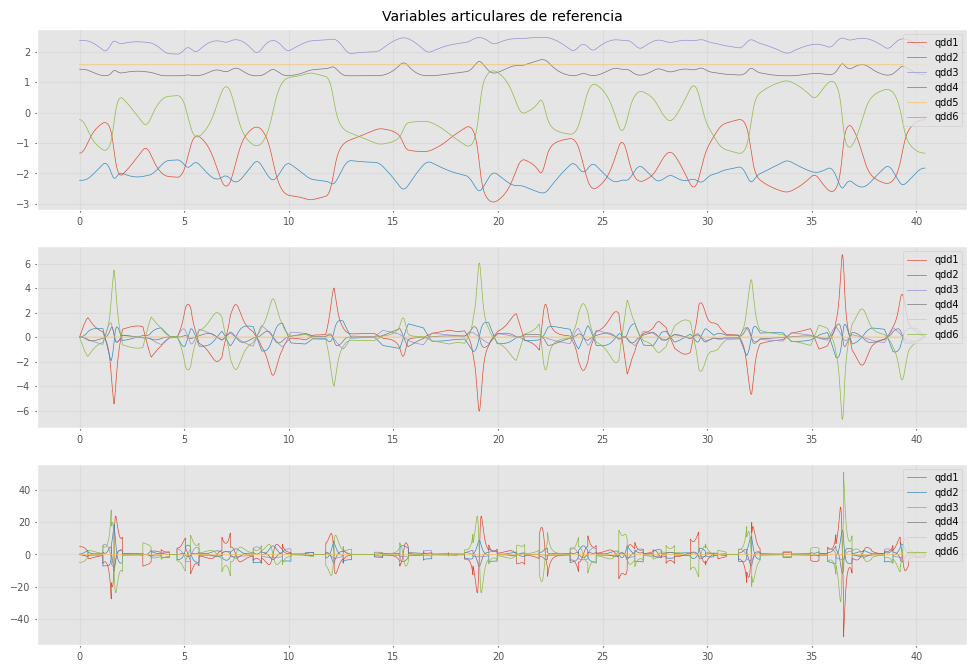

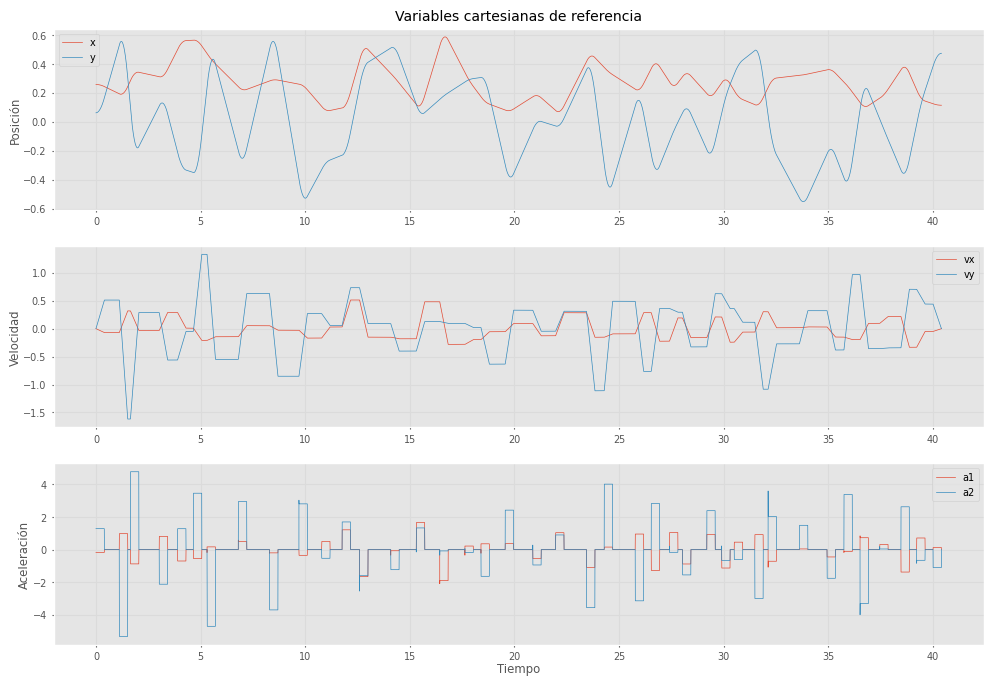

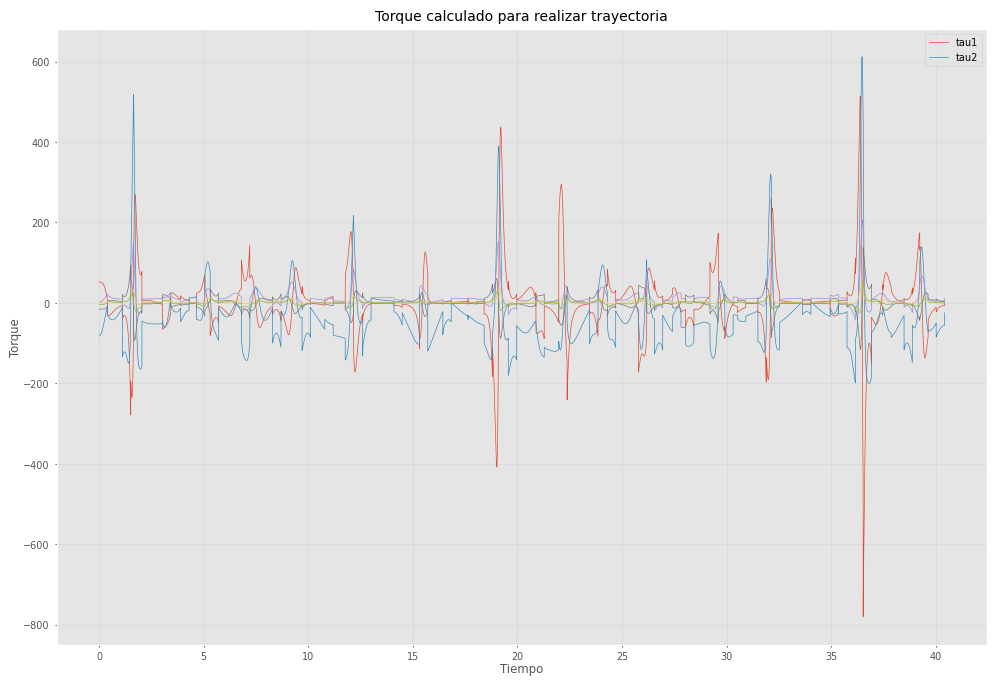

In [27]:
t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref = generateRandomDataSet(irb140,40,flag_joint_move=False,flag_plot=True)

In [28]:
nombre_archivo = f'./irb140_cartesianmovement_{fecha_actual}.csv'

cantidad = len(t_ref)

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Time, Theta_1, Theta_2, Theta_3, Theta_4, Theta_5, Theta_6, D_Theta_1, D_Theta_2, D_Theta_3, D_Theta_4, D_Theta_5, D_Theta_6, DD_Theta_1, DD_Theta_2, DD_Theta_3, DD_Theta_4, DD_Theta_5, DD_Theta_6, Torque_1, Torque_2, Torque_3, Torque_4, Torque_5, Torque_6\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        time = t_ref[_]
        j_1 = q_ref[_][0]
        j_2 = q_ref[_][1]
        j_3 = q_ref[_][2]
        j_4 = q_ref[_][3]
        j_5 = q_ref[_][4]
        j_6 = q_ref[_][5]                
        d_j_1 = qd_ref[_][0]
        d_j_2 = qd_ref[_][1]
        d_j_3 = qd_ref[_][2]
        d_j_4 = qd_ref[_][3]
        d_j_5 = qd_ref[_][4]
        d_j_6 = qd_ref[_][5]
        dd_j_1 = qdd_ref[_][0]
        dd_j_2 = qdd_ref[_][1]
        dd_j_3 = qdd_ref[_][2]
        dd_j_4 = qdd_ref[_][3]
        dd_j_5 = qdd_ref[_][4]
        dd_j_6 = qdd_ref[_][5]
        tau_1 = tau_ref[_][0]
        tau_2 = tau_ref[_][1]
        tau_3 = tau_ref[_][2]
        tau_4 = tau_ref[_][3]
        tau_5 = tau_ref[_][4]
        tau_6 = tau_ref[_][5]

        archivo.write((
            f'{id}, {time}, {j_1}, {j_2}, {j_3}, {j_4}, {j_5}, {j_6}, '
            f'{d_j_1}, {d_j_2}, {d_j_3}, {d_j_4}, {d_j_5}, {d_j_6}, '
            f'{dd_j_1}, {dd_j_2}, {dd_j_3}, {dd_j_4}, {dd_j_5}, {dd_j_6}, '
            f'{tau_1}, {tau_2}, {tau_3}, {tau_4}, {tau_5}, {tau_6}\n'))

# Forzando señales de Torque en Joints #

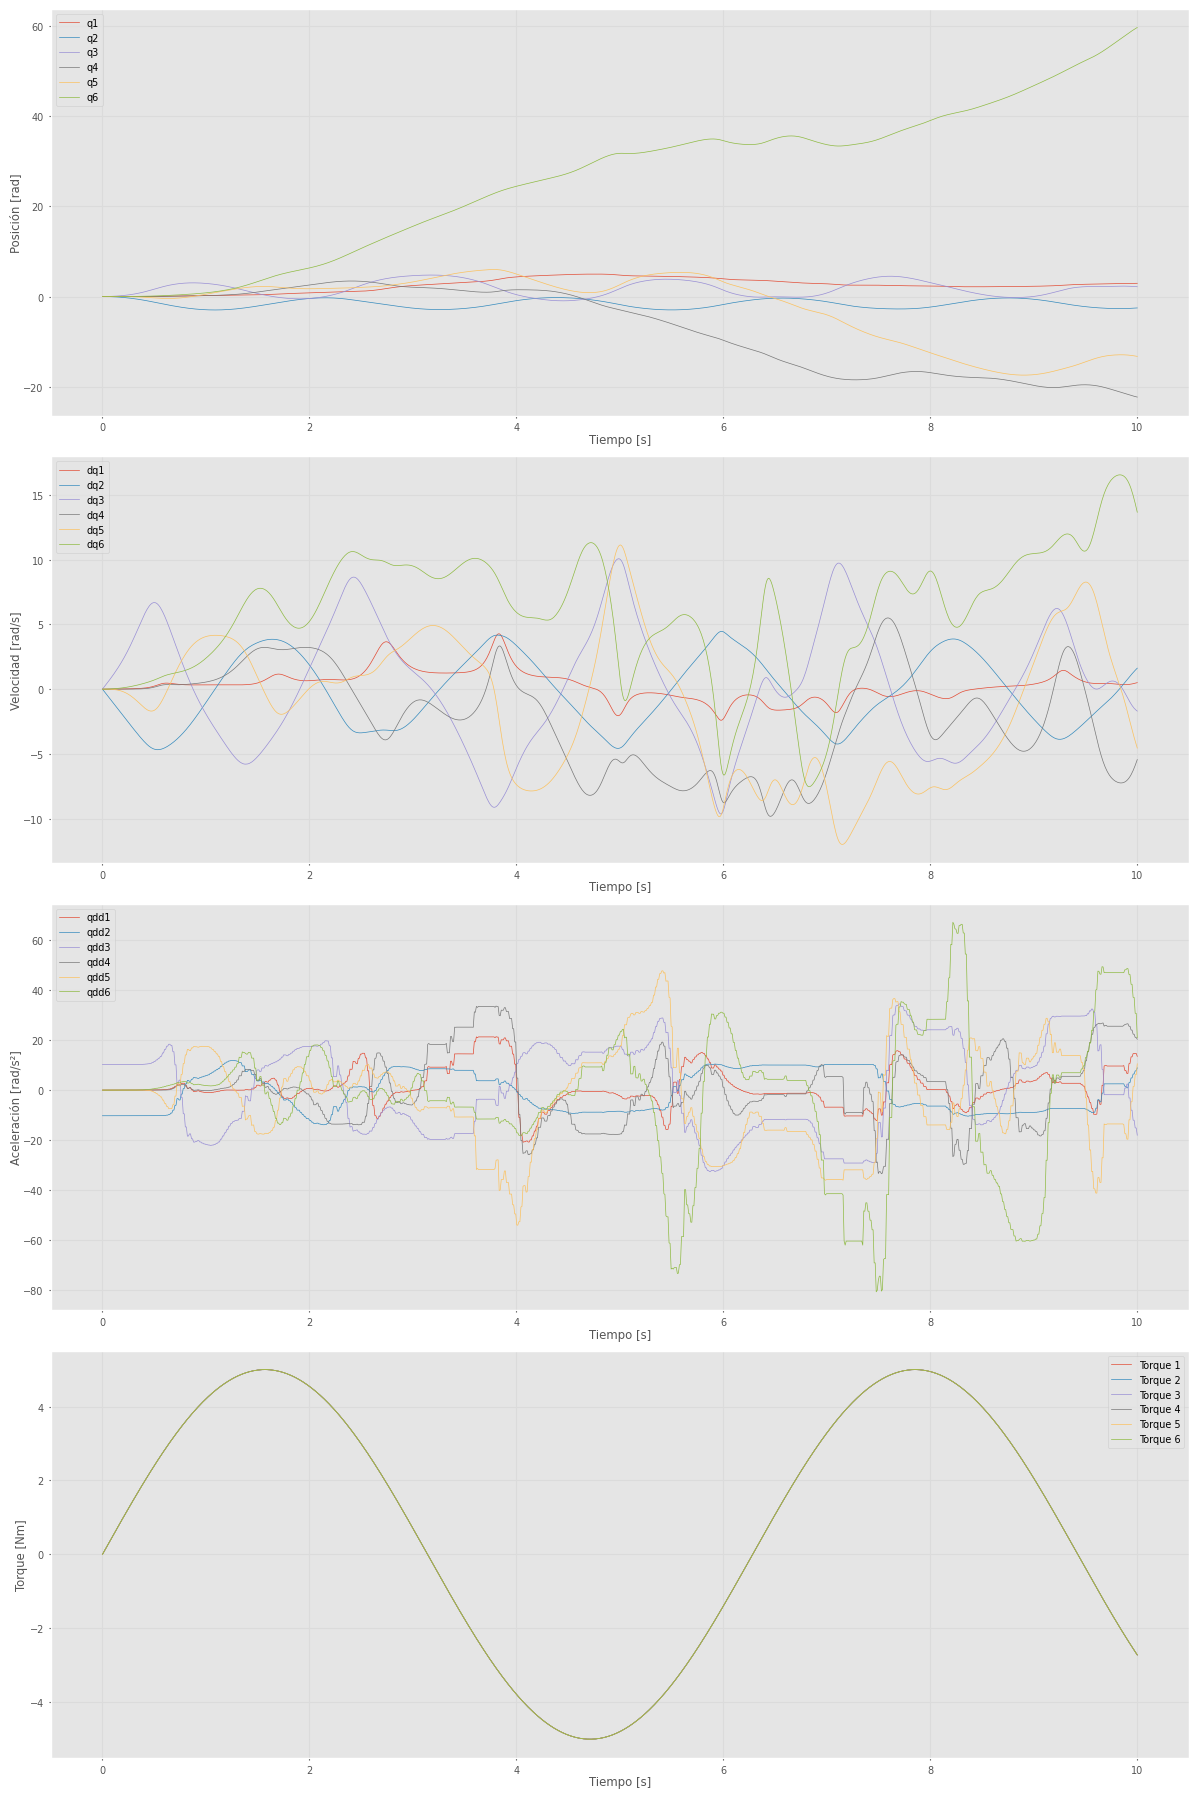

In [29]:
# Definir la función de torques en el tiempo
def applied_torques(t):
    # Torque sinusoidal aplicado a cada articulación
    return np.array([5*np.sin(t), 5*np.sin(t), 5*np.sin(t), 5*np.sin(t), 5*np.sin(t), 5*np.sin(t)])

# Lista para almacenar las aceleraciones
qdds_list = []

# Definir la función de dinámica del sistema
def dynamics(t, y):
    qs = y[:6].reshape(1, -1)  # Reshape para tener forma (1, 6)
    dqs = y[6:].reshape(1, -1)  # Reshape para tener forma (1, 6)
    torques = applied_torques(t).reshape(1, -1)  # Reshape para tener forma (1, 6)
    qdds = irb140.accel(qs, dqs, torques)  # Calcular aceleraciones
    qdds_list.append(qdds.ravel())  # Almacenar qdds como un vector
    return np.concatenate([dqs.ravel(), qdds.ravel()])

# Condiciones iniciales
starting_qs = np.zeros(6)  # Posiciones iniciales
starting_dqs = np.zeros(6)  # Velocidades iniciales
y0 = np.concatenate([starting_qs, starting_dqs])

# Intervalo de tiempo para la simulación
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Limpiar la lista de aceleraciones antes de ejecutar la simulación
qdds_list = []

# Resolver la ecuación diferencial
#sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='RK45') #Irregularidad en accel con torque senoidal
#sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='DOP853') #irregularidad en accel con torque constante pero no con senoidal
#sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='LSODA') #No funciona con torque cte y raro en senoidal
#sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='Radau') #No funciona con torque cte y raro en senoidal
sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='BDF')
#sol = solve_ivp(dynamics, t_span, y0, t_eval=t_eval, method='RK23')


# Convertir qdds_list a un array de numpy
qdds = np.array(qdds_list).T

# Extraer las soluciones
qs = sol.y[:6, :]
dqs = sol.y[6:, :]

# Calcular los torques para cada punto en el tiempo
torques = np.array([applied_torques(ti) for ti in t_eval])

# Graficar los resultados
plt.figure(figsize=(12, 18))

plt.subplot(4, 1, 1)
for i in range(6):
    plt.plot(sol.t, qs[i, :], label=f'q{i+1}')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [rad]')
plt.legend()

plt.subplot(4, 1, 2)
for i in range(6):
    plt.plot(sol.t, dqs[i, :], label=f'dq{i+1}')
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [rad/s]')
plt.legend()

plt.subplot(4, 1, 3)
for i in range(6):
    plt.plot(sol.t, qdds[i, :len(sol.t)], label=f'qdd{i+1}')  # Dimensiones coincidentes
plt.xlabel('Tiempo [s]')
plt.ylabel('Aceleración [rad/s²]')
plt.legend()

plt.subplot(4, 1, 4)
for i in range(6):
    plt.plot(sol.t, torques[:, i], label=f'Torque {i+1}')
plt.xlabel('Tiempo [s]')
plt.ylabel('Torque [Nm]')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
signal_type = 'sinusoidal'

nombre_archivo = f'./irb140_forcedtorques_{signal_type}_{fecha_actual}.csv'

cantidad = len(t_eval)

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Time, Theta_1, Theta_2, Theta_3, Theta_4, Theta_5, Theta_6, D_Theta_1, D_Theta_2, D_Theta_3, D_Theta_4, D_Theta_5, D_Theta_6, DD_Theta_1, DD_Theta_2, DD_Theta_3, DD_Theta_4, DD_Theta_5, DD_Theta_6, Torque_1, Torque_2, Torque_3, Torque_4, Torque_5, Torque_6\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        time = t_ref[_]
        j_1 = q_ref[_][0]
        j_2 = q_ref[_][1]
        j_3 = q_ref[_][2]
        j_4 = q_ref[_][3]
        j_5 = q_ref[_][4]
        j_6 = q_ref[_][5]                
        d_j_1 = qd_ref[_][0]
        d_j_2 = qd_ref[_][1]
        d_j_3 = qd_ref[_][2]
        d_j_4 = qd_ref[_][3]
        d_j_5 = qd_ref[_][4]
        d_j_6 = qd_ref[_][5]
        dd_j_1 = qdd_ref[_][0]
        dd_j_2 = qdd_ref[_][1]
        dd_j_3 = qdd_ref[_][2]
        dd_j_4 = qdd_ref[_][3]
        dd_j_5 = qdd_ref[_][4]
        dd_j_6 = qdd_ref[_][5]
        tau_1 = tau_ref[_][0]
        tau_2 = tau_ref[_][1]
        tau_3 = tau_ref[_][2]
        tau_4 = tau_ref[_][3]
        tau_5 = tau_ref[_][4]
        tau_6 = tau_ref[_][5]

        archivo.write((
            f'{id}, {time}, {j_1}, {j_2}, {j_3}, {j_4}, {j_5}, {j_6}, '
            f'{d_j_1}, {d_j_2}, {d_j_3}, {d_j_4}, {d_j_5}, {d_j_6}, '
            f'{dd_j_1}, {dd_j_2}, {dd_j_3}, {dd_j_4}, {dd_j_5}, {dd_j_6}, '
            f'{tau_1}, {tau_2}, {tau_3}, {tau_4}, {tau_5}, {tau_6}\n'))
        
